In [1]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(19, 11)}, font_scale=2)

# Distribution of Wikipage categories in the dataset

## Wikipages Dataset

In [2]:
wikipage_to_categories_path = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/wikipage_to_categories.json'
category_to_num_occurrences_path='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/category_to_num_occurrences.json'
wikipage_relevance_scores_path='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard/'
filtered_queries_df_path='../../data/tables/wikipages/wikipages_filtered_df.pickle'

with open(wikipage_to_categories_path) as fp:
    wikipage_to_categories = json.load(fp)
with open(category_to_num_occurrences_path) as fp:
    category_to_num_occurrences = json.load(fp)

In [3]:
# Extract into a list the number of categories for each wikipage
num_categories_per_wikipage_list = [len(wikipage_to_categories[wikipage]) for wikipage in wikipage_to_categories]

# Extract into a list the number of wikipages a category appears in
num_wikipages_per_category_list = list(category_to_num_occurrences.values())

# Extract into a list the number of relevant wikipages for each query
num_relevant_wikipages_per_wikipage_list = []
queries_wikipage_ids = set(pd.read_pickle(filtered_queries_df_path)['wikipage_id'])
for file in sorted(os.listdir(wikipage_relevance_scores_path)):
    wikipage_id = int(file.split('.')[0])
    if wikipage_id in queries_wikipage_ids:
        with open(wikipage_relevance_scores_path+file, 'r') as fp:
            relevance_dict = json.load(fp)
        num_relevant_wikipages_per_wikipage_list.append(len(relevance_dict))

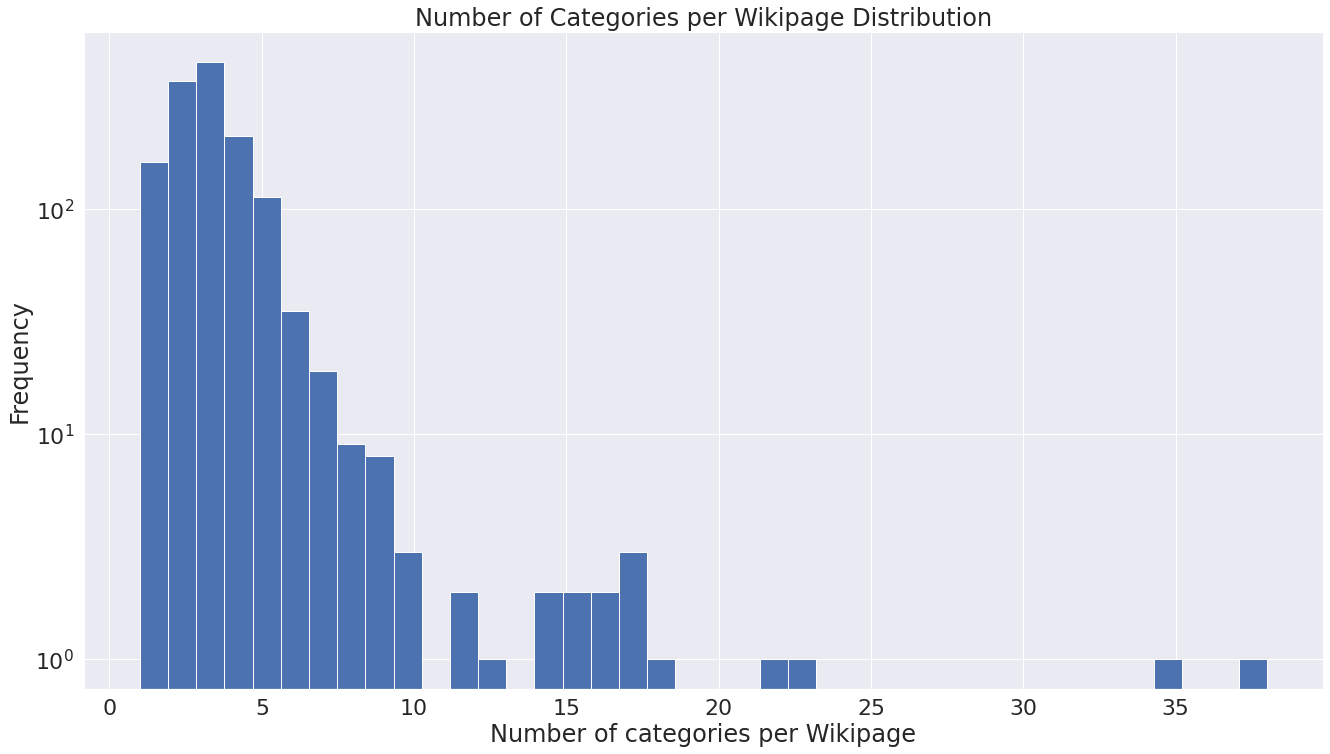

In [4]:
ax = plt.hist(num_categories_per_wikipage_list, bins=40)
plt.yscale('log');plt.xlabel("Number of categories per Wikipage");plt.ylabel('Frequency');plt.title('Number of Categories per Wikipage Distribution');plt.tight_layout()
plt.savefig('figures/wikipage_categories/num_categories_per_wikipage.svg')

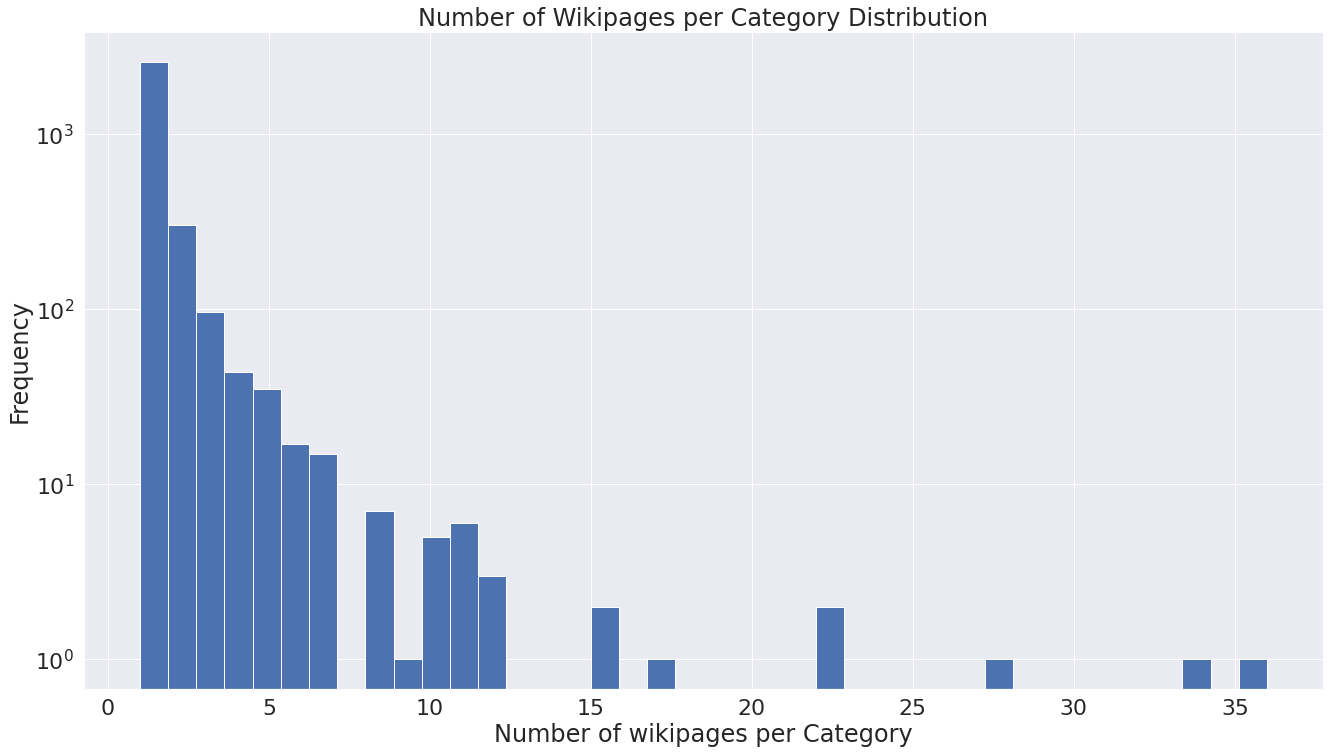

In [5]:
ax = plt.hist(num_wikipages_per_category_list, bins=40)
plt.yscale('log');plt.xlabel("Number of wikipages per Category");plt.ylabel('Frequency');plt.title('Number of Wikipages per Category Distribution');plt.tight_layout()
plt.savefig('figures/wikipage_categories/num_wikipages_per_category.svg')

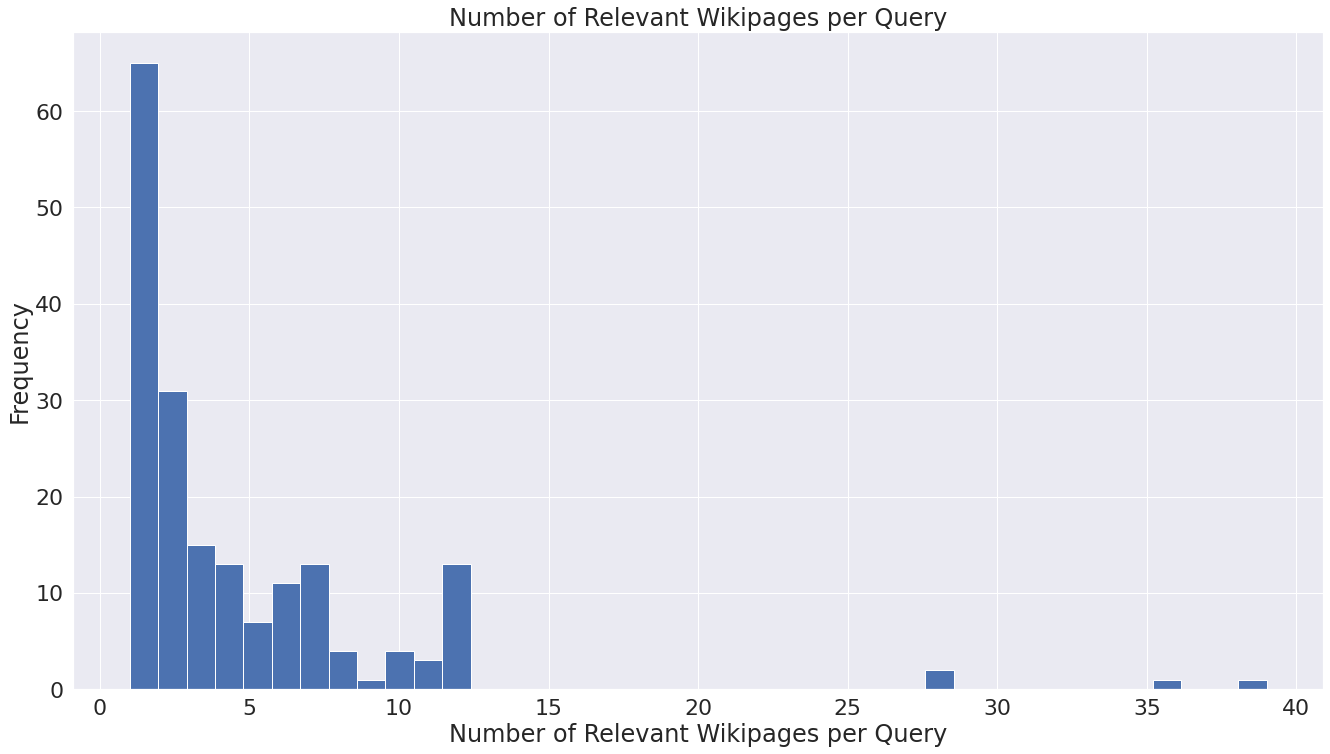

In [6]:
ax = plt.hist(num_relevant_wikipages_per_wikipage_list, bins=40)
plt.xlabel("Number of Relevant Wikipages per Query");plt.ylabel('Frequency');plt.title('Number of Relevant Wikipages per Query');plt.tight_layout()
plt.savefig('figures/wikipage_categories/num_relevant_wikipages_per_query.svg')

## Expanded Wikipages Dataset

In [7]:
wikipage_to_categories_path = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/wikipage_to_categories.json'
category_to_num_occurrences_path='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/category_to_num_occurrences.json'
wikipage_relevance_scores_path='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/jaccard/'

with open(wikipage_to_categories_path) as fp:
    wikipage_to_categories = json.load(fp)
with open(category_to_num_occurrences_path) as fp:
    category_to_num_occurrences = json.load(fp)

In [8]:
# Extract into a list the number of categories for each wikipage
num_categories_per_wikipage_list = [len(wikipage_to_categories[wikipage]) for wikipage in wikipage_to_categories]

# Extract into a list the number of wikipages a category appears in
num_wikipages_per_category_list = list(category_to_num_occurrences.values())

# Extract into a list the number of relevant wikipages for each query
num_relevant_wikipages_per_wikipage_list = []
queries_wikipage_ids = set(pd.read_pickle(filtered_queries_df_path)['wikipage_id'])
for file in sorted(os.listdir(wikipage_relevance_scores_path)):
    wikipage_id = int(file.split('.')[0])
    if wikipage_id in queries_wikipage_ids:
        with open(wikipage_relevance_scores_path+file, 'r') as fp:
            relevance_dict = json.load(fp)
        num_relevant_wikipages_per_wikipage_list.append(len(relevance_dict))

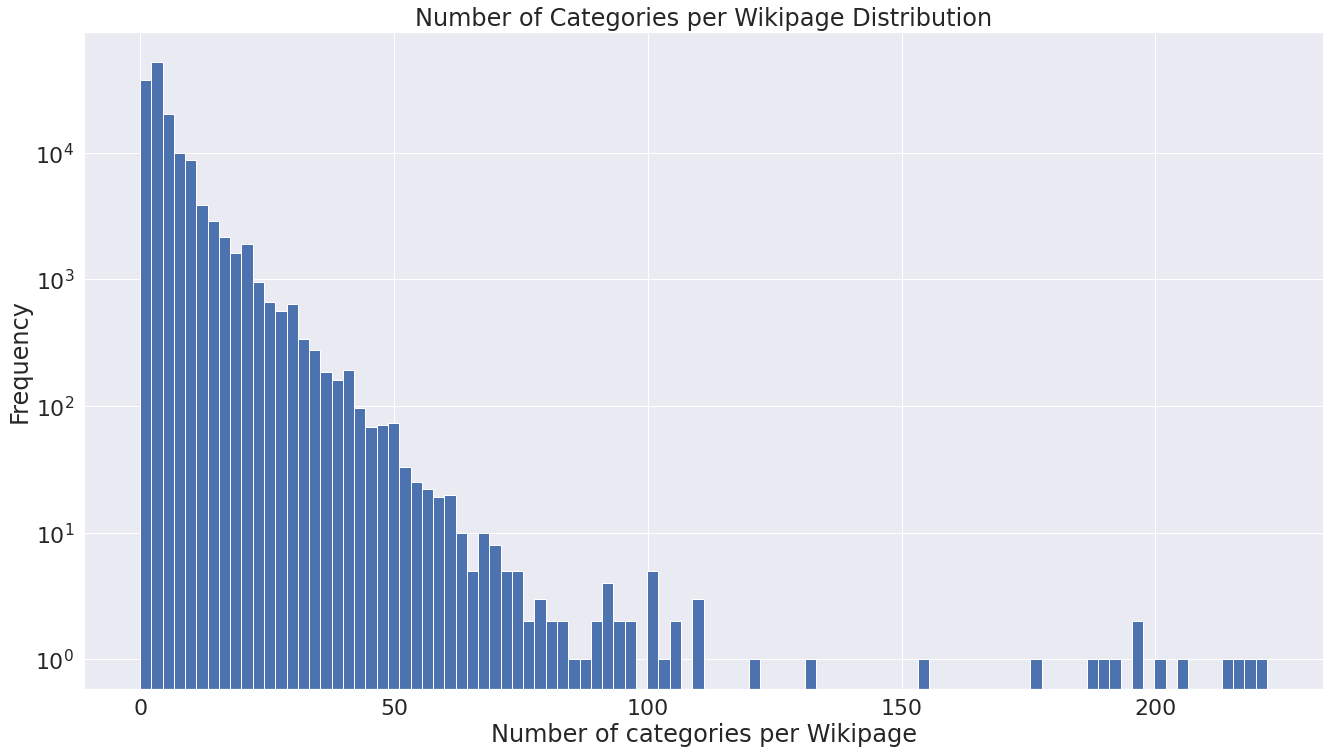

In [10]:
ax = plt.hist(num_categories_per_wikipage_list, bins=100)
plt.yscale('log');plt.xlabel("Number of categories per Wikipage");plt.ylabel('Frequency');plt.title('Number of Categories per Wikipage Distribution');plt.tight_layout()
# plt.savefig('figures/wikipage_categories/num_categories_per_wikipage.svg')

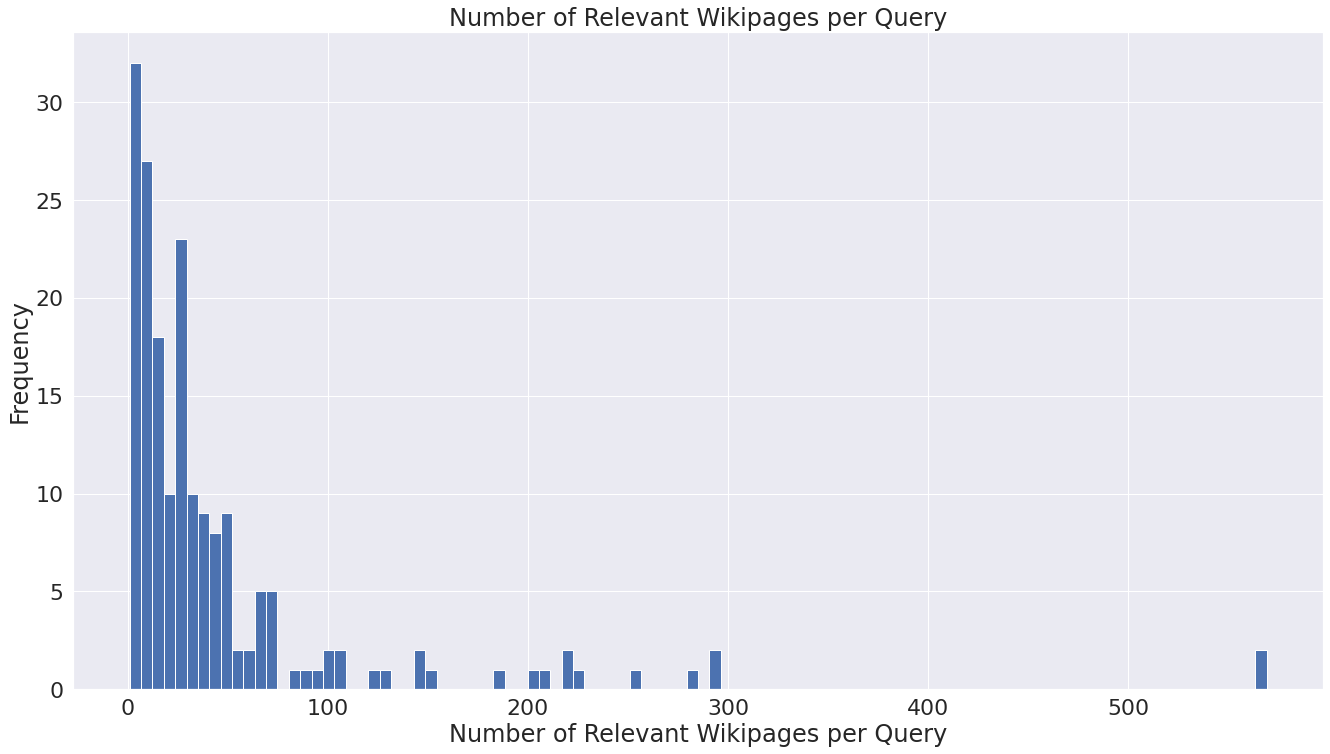

In [14]:
ax = plt.hist(num_relevant_wikipages_per_wikipage_list, bins=100)
plt.xlabel("Number of Relevant Wikipages per Query");plt.ylabel('Frequency');plt.title('Number of Relevant Wikipages per Query');plt.tight_layout()
# plt.savefig('figures/wikipage_categories/num_relevant_wikipages_per_query.svg')

# Evaluation using Wikipage Categories (Brute Force Search)

In [69]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_mean_ndcg_scores_at_k(df_dict, top_k_vals, tuples_per_query_list):
    mean_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
    return mean_ndcg_scores_at_k

In [70]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/'
score_paths_base_dir = 'eval_over_search_output/wikipage_categories_relevant/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10, 15, 20]

# Updated Dataframes for Wikipages with Categories (Jaccard)
query_df_categories_jaccard = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard',
    tuples_per_query_list=tuples_per_query_list
)

# Updated Dataframes for Wikipages with Categories (Weighted)
query_df_categories_weighted = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'weighted',
    tuples_per_query_list=tuples_per_query_list
)

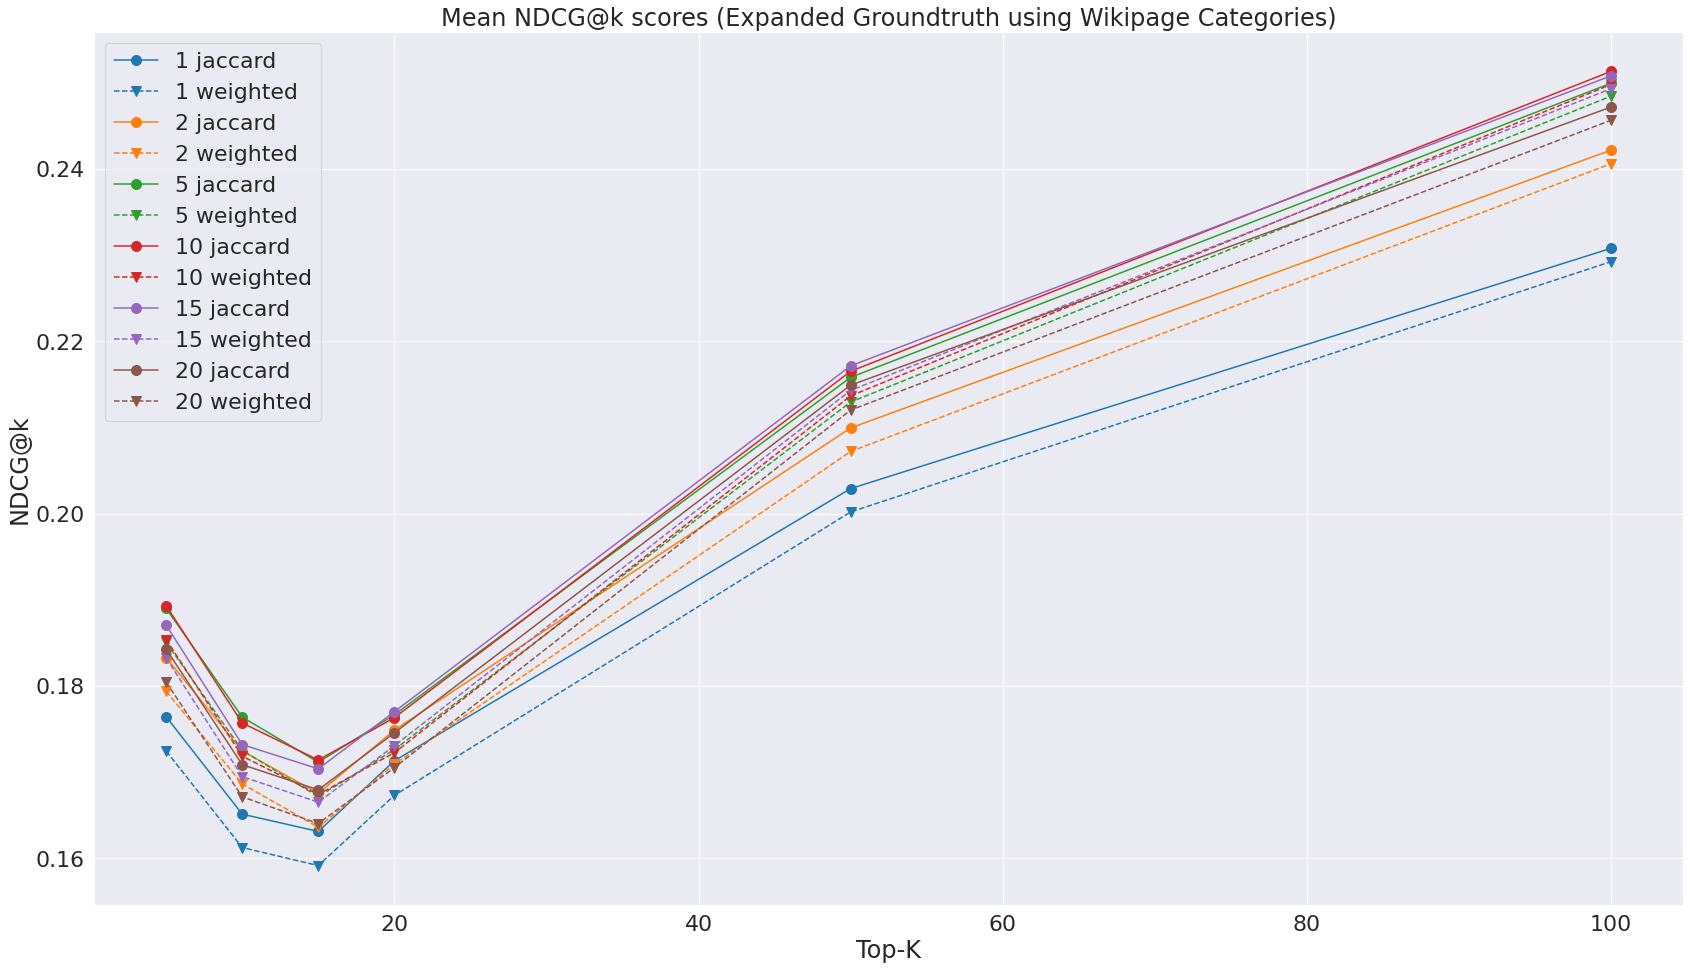

In [71]:
top_k_vals = [5,10,15,20,50,100]

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_categories_jaccard = get_mean_ndcg_scores_at_k(query_df_categories_jaccard, top_k_vals, tuples_per_query_list)
mean_ndcg_scores_at_k_categories_weighted = get_mean_ndcg_scores_at_k(query_df_categories_weighted, top_k_vals, tuples_per_query_list)


colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_jaccard[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' jaccard')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_weighted[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' weighted')

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (Expanded Groundtruth using Wikipage Categories)');plt.legend();plt.tight_layout()
plt.savefig('figures/wikipage_categories/topk_ndcg@k_brute_force.svg')

## Brute Force (Adjusted Jaccard Similarity)

In [72]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/'
score_paths_base_dir = 'eval_over_search_output/wikipage_categories_adjusted_jaccard_sim/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10]

# Updated Dataframes for Wikipages with Categories (Jaccard)
query_df_categories_adjusted_jaccard_sim = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard',
    tuples_per_query_list=tuples_per_query_list
)

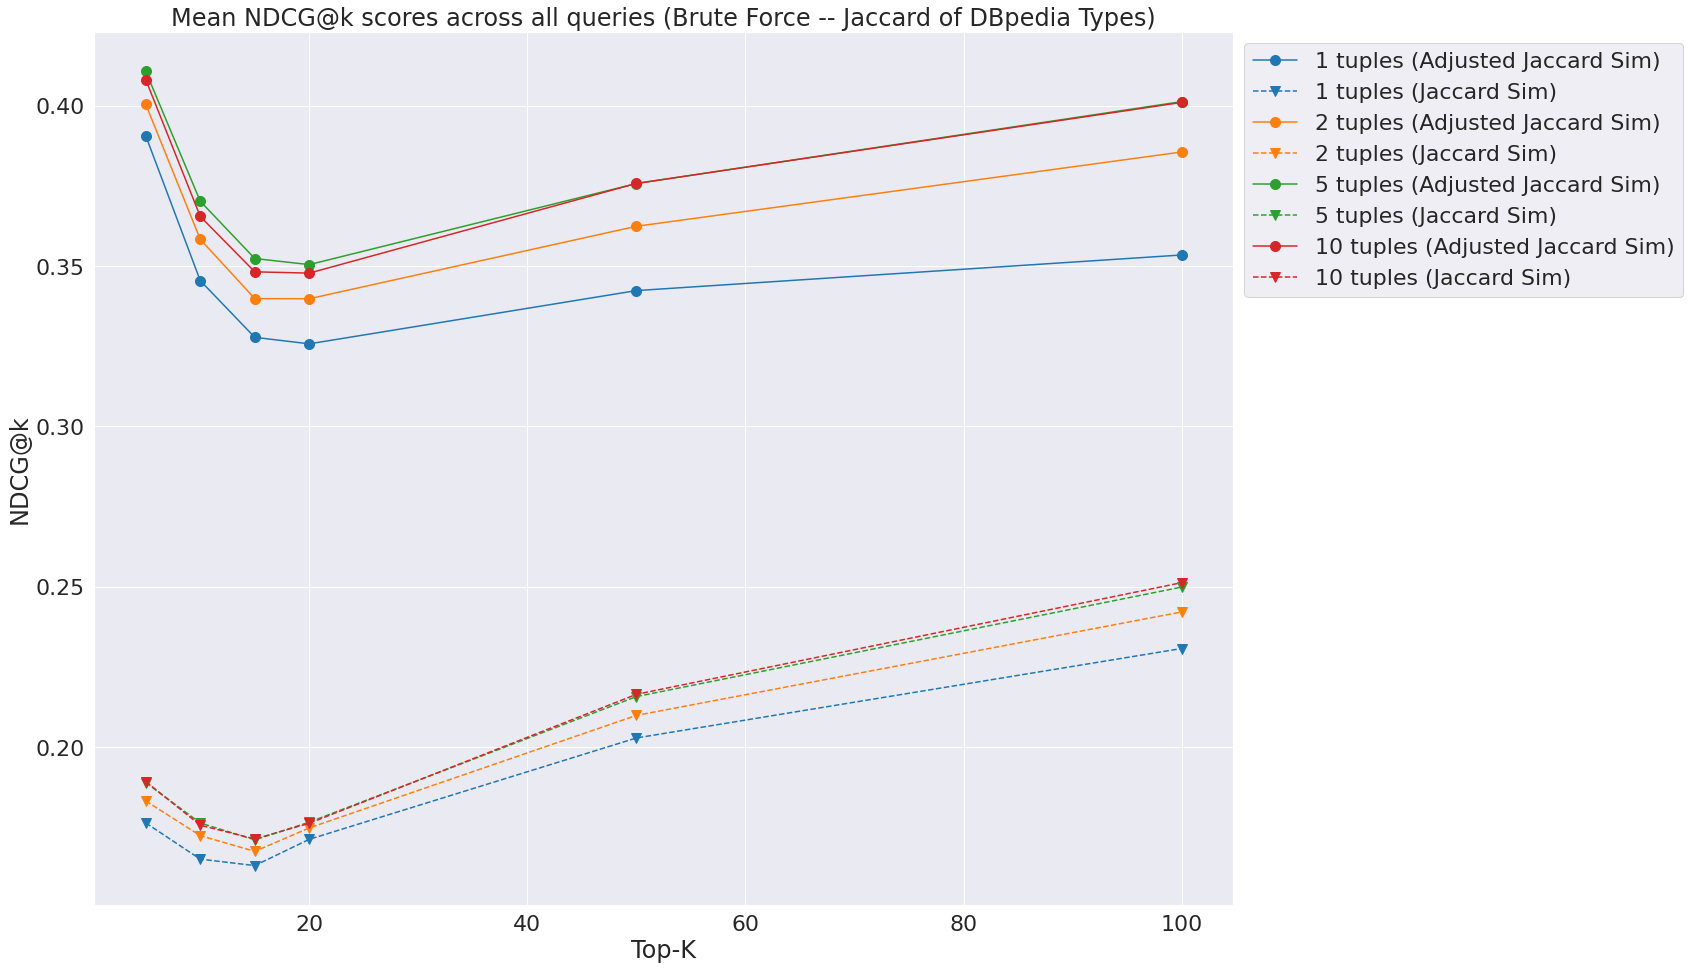

In [77]:
sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)
top_k_vals = [5,10,15,20,50,100]

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_categories_jaccard_sim = get_mean_ndcg_scores_at_k(query_df_categories_adjusted_jaccard_sim, top_k_vals, tuples_per_query_list)

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_jaccard_sim[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Adjusted Jaccard Sim)')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_jaccard[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Jaccard Sim)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores across all queries (Brute Force -- Jaccard of DBpedia Types)');plt.tight_layout()
plt.savefig('figures/wikipage_categories/topk_ndcg@k_brute_force_adjusted_jaccard.svg')
plt.savefig('figures/wikipage_categories/topk_ndcg@k_brute_force_adjusted_jaccard.png')

## Filtered Dataset (Removed queries that are relevant with only one wikipage)

In [74]:
wikipage_ids_with_multiple_relevant_wikipages = []
for query_id in queries_wikipage_ids:
    with open(wikipage_relevance_scores_path + str(query_id) + '.json', 'r') as fp:
        relevance_scores = json.load(fp) 

    if len(relevance_scores) > 1:
        wikipage_ids_with_multiple_relevant_wikipages.append(query_id)

print(len(wikipage_ids_with_multiple_relevant_wikipages), 'of the', len(queries_wikipage_ids), 'queries have non-zero relevance to wikipages other than themselves')

119 of the 184 queries have non-zero relevance to wikipages other than themselves


In [75]:
def get_filtered_dict(input_dict, wikipage_ids_to_keep):
    filtered_dict = {}
    for tuples_per_query in input_dict:
        cur_df = input_dict[tuples_per_query]
        filtered_df = cur_df[cur_df['wikipage_id'].isin(wikipage_ids_to_keep)]
        filtered_dict[tuples_per_query] = filtered_df
    return filtered_dict

query_df_categories_adjusted_jaccard_sim_filtered = get_filtered_dict(query_df_categories_adjusted_jaccard_sim, wikipage_ids_with_multiple_relevant_wikipages)
query_df_categories_jaccard_filtered = get_filtered_dict(query_df_categories_jaccard, wikipage_ids_with_multiple_relevant_wikipages)

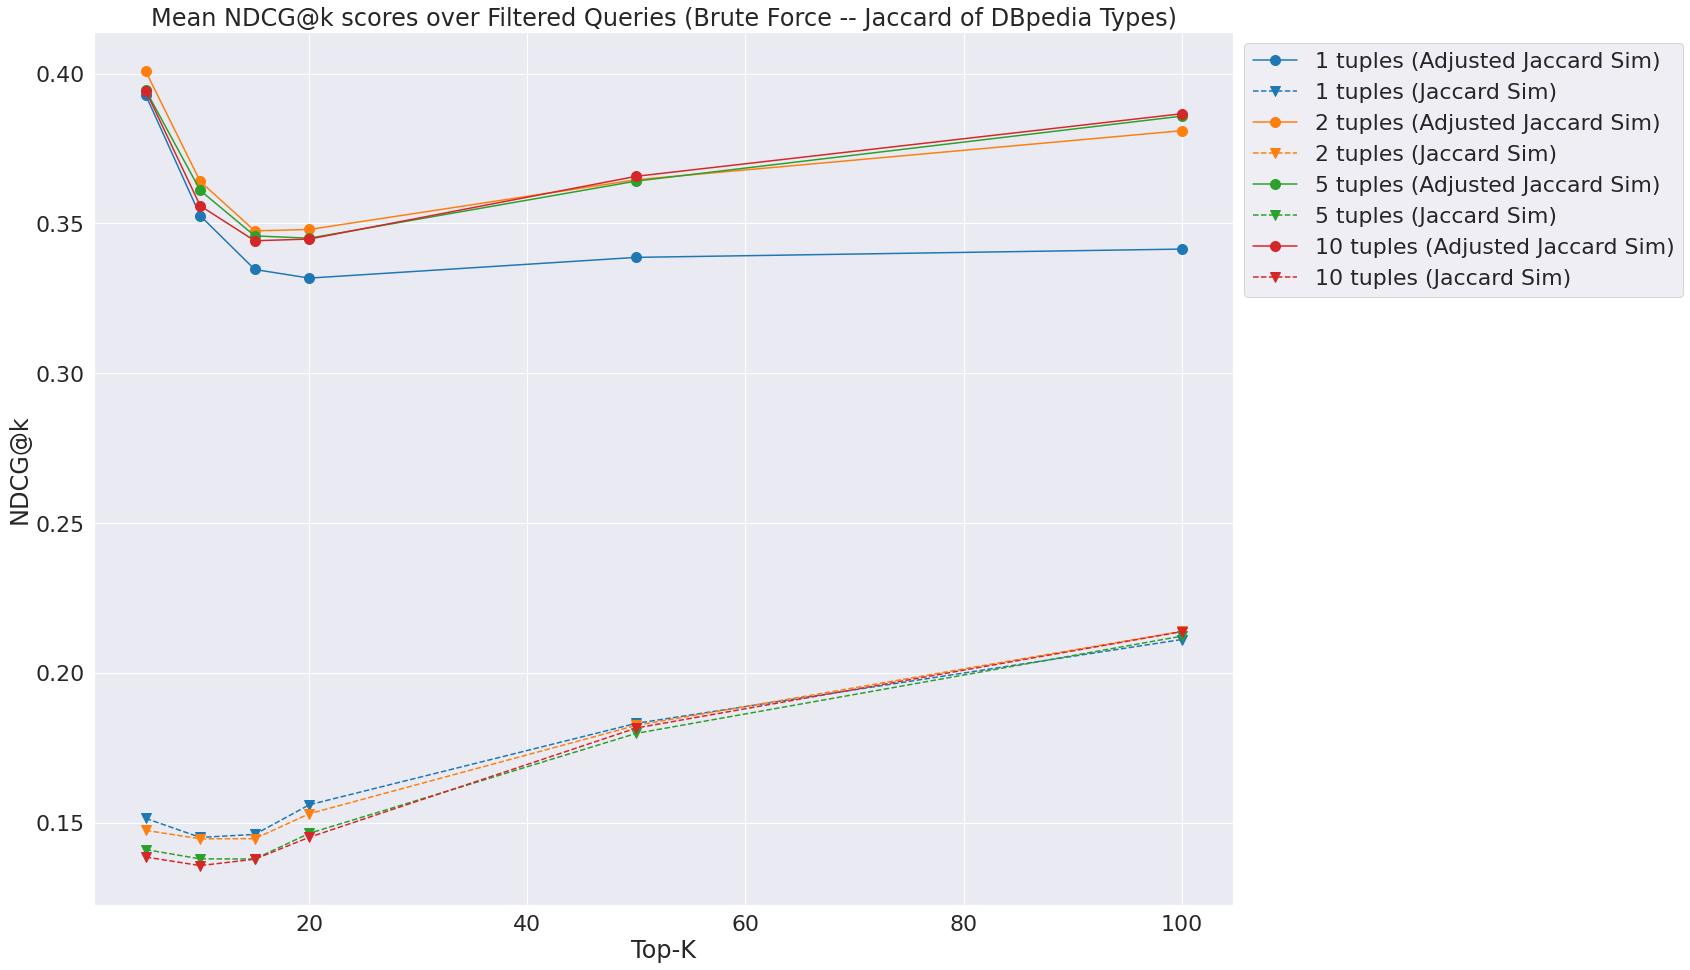

In [76]:
# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_categories_jaccard_sim_filtered = get_mean_ndcg_scores_at_k(query_df_categories_adjusted_jaccard_sim_filtered, top_k_vals, tuples_per_query_list)
mean_ndcg_scores_at_k_categories_jaccard_filtered = get_mean_ndcg_scores_at_k(query_df_categories_jaccard_filtered, top_k_vals, tuples_per_query_list)

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_jaccard_sim_filtered[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Adjusted Jaccard Sim)')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_jaccard_filtered[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Jaccard Sim)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores over Filtered Queries (Brute Force -- Jaccard of DBpedia Types)');plt.tight_layout()
# plt.savefig('figures/wikipage_categories/topk_ndcg@k_brute_force_adjusted_jaccard.svg')

# Evaluating using Wikipage Categories (BM25)

In [32]:
full_df_path="../../data/queries/wikipages/query_dataframes/minTupleWidth_all_tuplesPerQuery_all.pickle"
full_df = pd.read_pickle(full_df_path)
groundtruth_relevance_scores_dir_jaccard='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard/'
groundtruth_relevance_scores_dir_weighted='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/weighted/'
tables_path = '../../data/tables/wikipages/wikipages_dataset/tables/'

# Extract the names of all tables in our search space
tables_list = os.listdir(tables_path)

In [5]:
# tmp_df = pd.read_pickle('../../data/queries/wikipages/query_dataframes/minTupleWidth_2_tuplesPerQuery_10.pickle')
# df_content_text_jaccard = utils.bm25_evaluation.get_updated_df(df=tmp_df.copy(), full_df=full_df,
#     scores_path='../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/minTupleWidth_2_tuplesPerQuery_10/entities/content.txt',
#     k_vals=[5,10,15,20,50,100], groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_jaccard, tables_list=tables_list)
# df_content_text_jaccard

100%|██████████| 6/6 [00:17<00:00,  2.97s/it]


,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,10.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22]",0.000000,0.339160,0.220092,0.205212,0.193508,0.178678,0.185387
2735,https://en.wikipedia.org/wiki/List_of_Paramoun...,2735,12,"[table-0017-696.json, table-0017-697.json, tab...","[21, 129, 52, 19, 22, 20, 89, 79, 108, 80, 83,...",2.0,10.0,table-0017-697.json,"[2, 4, 6, 7, 9, 10, 11, 12, 14, 17]",0.045455,0.868795,0.563788,0.545759,0.573353,0.523837,0.523837
3381,https://en.wikipedia.org/wiki/Los_Angeles_Lake...,3381,16,"[table-0022-127.json, table-0022-128.json, tab...","[25, 28, 23, 64, 26, 43, 51, 24, 33, 58, 52, 2...",3.0,10.0,table-0022-130.json,"[0, 1, 2, 3, 4, 8, 9, 10, 11, 12]",0.092063,0.403646,0.274663,0.224809,0.215150,0.183349,0.172339
5740,https://en.wikipedia.org/wiki/2007_IIHF_World_...,5740,16,"[table-0038-375.json, table-0038-377.json, tab...","[24, 21, 30, 22, 26, 20, 22, 34, 18, 12, 28, 1...",2.0,10.0,table-0038-390.json,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]",0.040741,0.515705,0.383934,0.297615,0.271827,0.208416,0.177856
5846,https://en.wikipedia.org/wiki/List_of_Roman_co...,5846,12,"[table-0039-315.json, table-0039-316.json, tab...","[13, 78, 62, 26, 31, 23, 53, 75, 121, 113, 76,...",2.0,10.0,table-0039-316.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.040404,1.000000,0.921602,0.981629,0.981629,0.981629,0.981629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235493,https://en.wikipedia.org/wiki/List_of_sportspe...,235493,11,"[table-1597-523.json, table-1597-524.json, tab...","[96, 22, 53, 29, 88, 201, 192, 30, 36, 137, 36]",4.0,10.0,table-1597-533.json,"[1, 2, 8, 13, 19, 23, 27, 32, 33, 34]",0.015152,0.339160,0.220092,0.198796,0.189895,0.176338,0.205407
236836,https://en.wikipedia.org/wiki/List_of_doping_c...,236836,24,"[table-1606-361.json, table-1606-362.json, tab...","[99, 31, 88, 65, 119, 45, 28, 68, 74, 123, 91,...",3.0,10.0,table-1606-361.json,"[0, 1, 10, 16, 20, 28, 34, 35, 43, 52]",0.183230,1.000000,0.823072,0.826291,0.768763,0.848094,0.864343
239032,https://en.wikipedia.org/wiki/Missouri's_8th_c...,239032,11,"[table-1620-704.json, table-1620-705.json, tab...","[24, 28, 122, 26, 28, 28, 30, 28, 28, 18, 28]",2.0,10.0,table-1620-706.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.438889,0.830420,0.742125,0.867541,0.867541,0.867541,0.867541
239349,https://en.wikipedia.org/wiki/List_of_Internat...,239349,10,"[table-1622-662.json, table-1622-663.json, tab...","[21, 17, 17, 12, 10, 24, 16, 13, 20, 25]",5.0,10.0,table-1622-676.json,"[3, 5, 6, 9, 10, 11, 12, 14, 15, 16]",0.144444,0.570148,0.546662,0.710742,0.843138,0.809611,0.809611


In [7]:
min_tuple_width=2
bm25_scores_base_path='../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/'
query_dfs_path='../../data/queries/wikipages/query_dataframes/'
tuples_per_query_list = [1, 2, 5, 10, 15, 20]
top_k_vals = [5,10,15,20,50,100]

# Dictionary keyed by tuples per query and maps to another dictionary keyed by 'entities' and 'text'
# which in turn map to a dictionary keyed by 'catchall', 'content', etc. and map to their respective dataframes with NDCG scores
dfs_dict = {}

for tuples_per_query in tqdm(tuples_per_query_list):
    base_num_tuples_path='minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_'+str(tuples_per_query)
    bm25_scores_path_entities = bm25_scores_base_path+base_num_tuples_path+'/entities/'
    bm25_scores_path_text = bm25_scores_base_path+base_num_tuples_path+'/text/'

    # Read the query dataframe
    df = pd.read_pickle(query_dfs_path + base_num_tuples_path+'.pickle')

    # Construct the modified dataframes with the NDCG scores

    # Text Queries
    df_content_text_jaccard = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_jaccard)
    df_content_text_weighted = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_weighted)

    # Entity Queries
    df_content_entities_jaccard = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_jaccard)
    df_content_entities_weighted = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_weighted)

    # Update dfs_dict
    dfs_dict[tuples_per_query] = {}
    dfs_dict[tuples_per_query]['entities'] = {'content_jaccard': df_content_entities_jaccard, 'content_weighted': df_content_entities_weighted}
    dfs_dict[tuples_per_query]['text'] = {'content_jaccard': df_content_text_jaccard,'content_weighted': df_content_text_weighted} 

100%|██████████| 6/6 [07:36<00:00, 76.12s/it]


In [11]:
with open('bm25_dfs_dict.pickle', 'wb') as handle:
    pickle.dump(dfs_dict, handle)

In [33]:
with open('bm25_dfs_dict.pickle', 'rb') as handle:
    dfs_dict = pickle.load(handle)

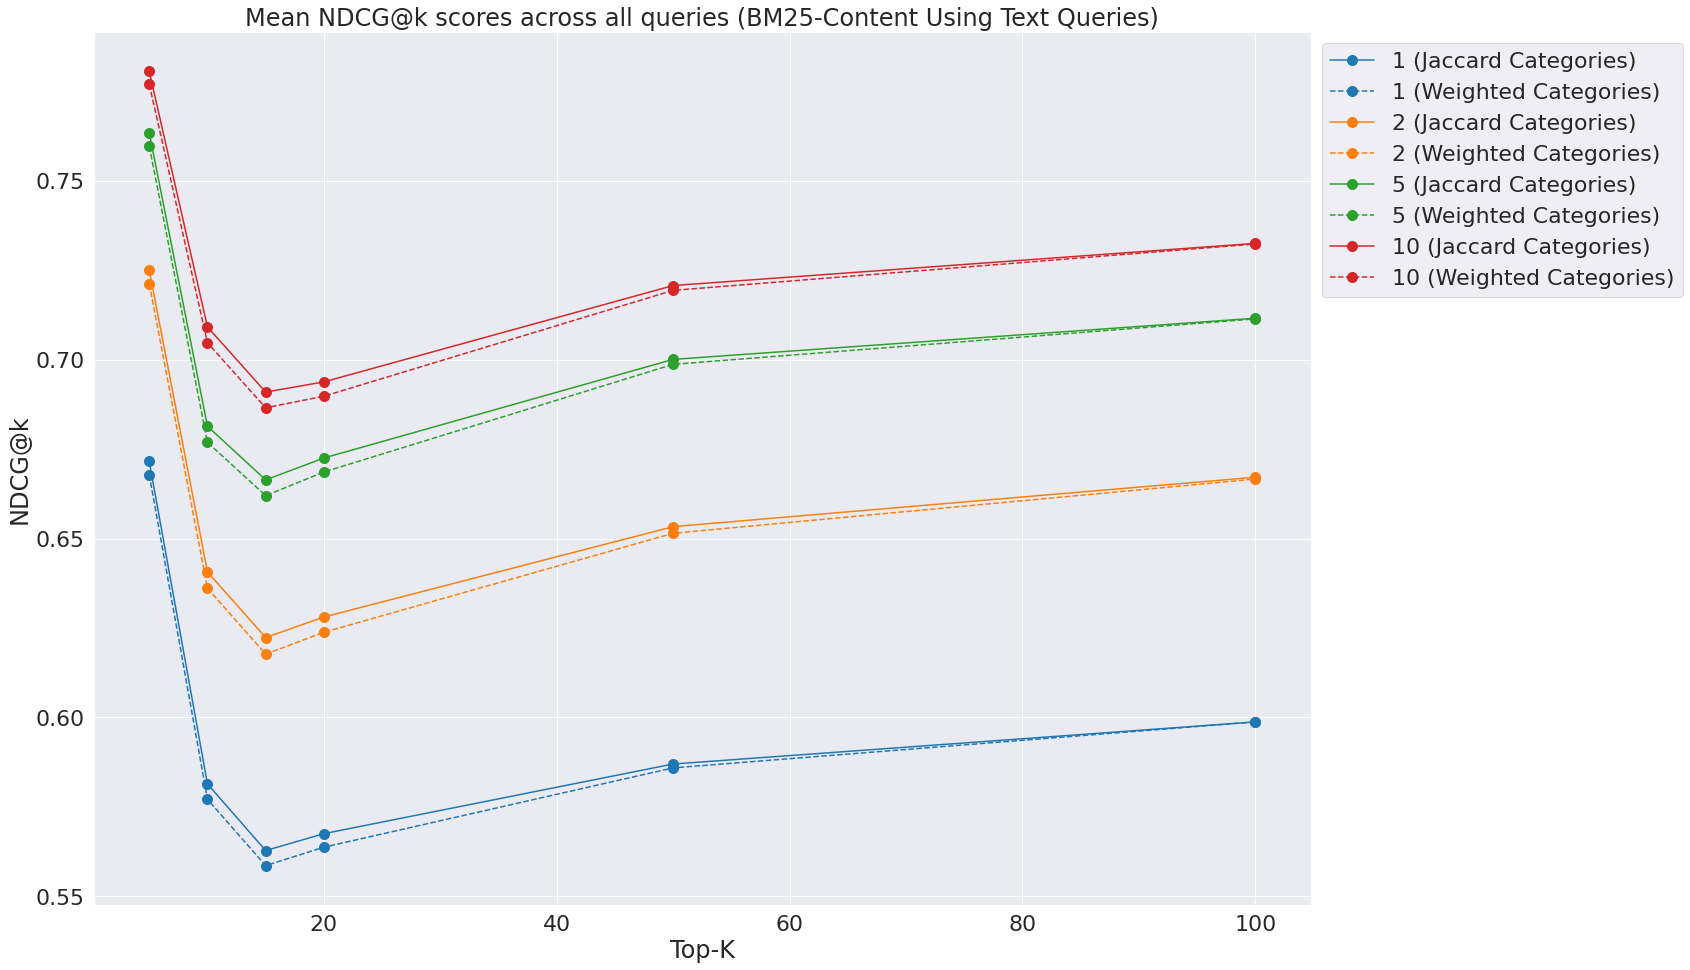

In [78]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_jaccard = [dfs_dict[tuples_per_query_list[i]]['text']['content_jaccard']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_weighted = [dfs_dict[tuples_per_query_list[i]]['text']['content_weighted']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_jaccard, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Jaccard Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_weighted, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Weighted Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores across all queries (BM25-Content Using Text Queries)');plt.tight_layout()
plt.savefig('figures/wikipage_categories/bm25_content_text_queries.svg')

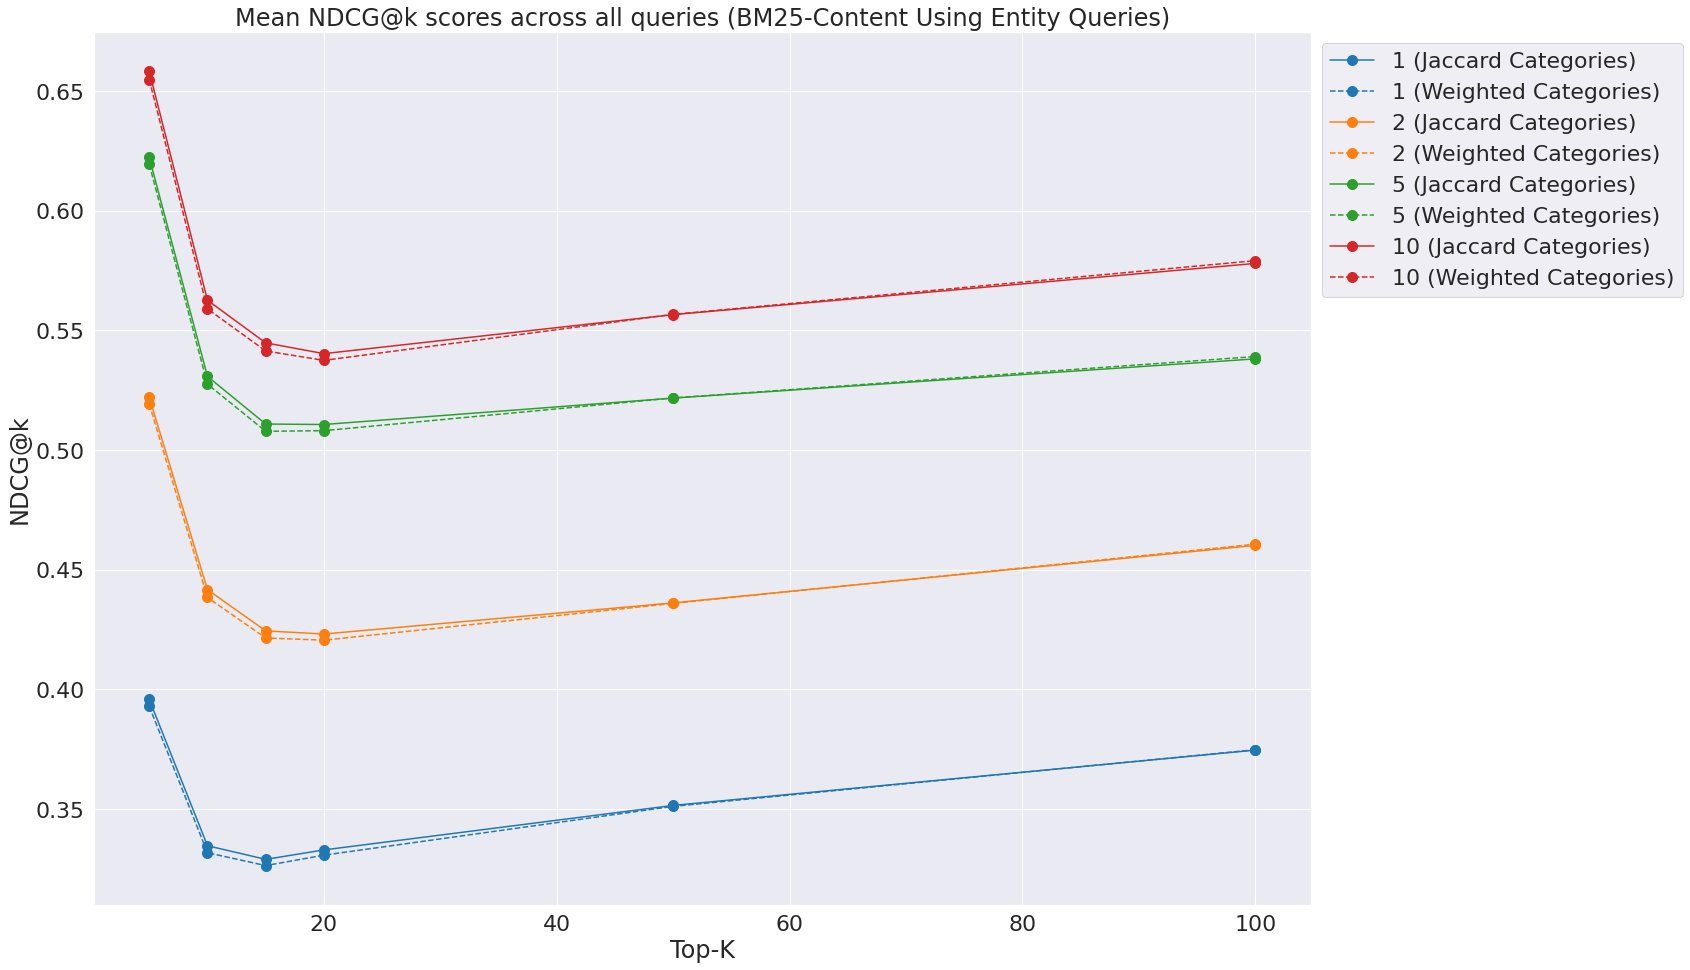

In [35]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_jaccard = [dfs_dict[tuples_per_query_list[i]]['entities']['content_jaccard']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_weighted = [dfs_dict[tuples_per_query_list[i]]['entities']['content_weighted']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_jaccard, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Jaccard Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_weighted, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Weighted Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores across all queries (BM25-Content Using Entity Queries)');plt.tight_layout()
plt.savefig('figures/wikipage_categories/bm25_content_entity_queries.svg')

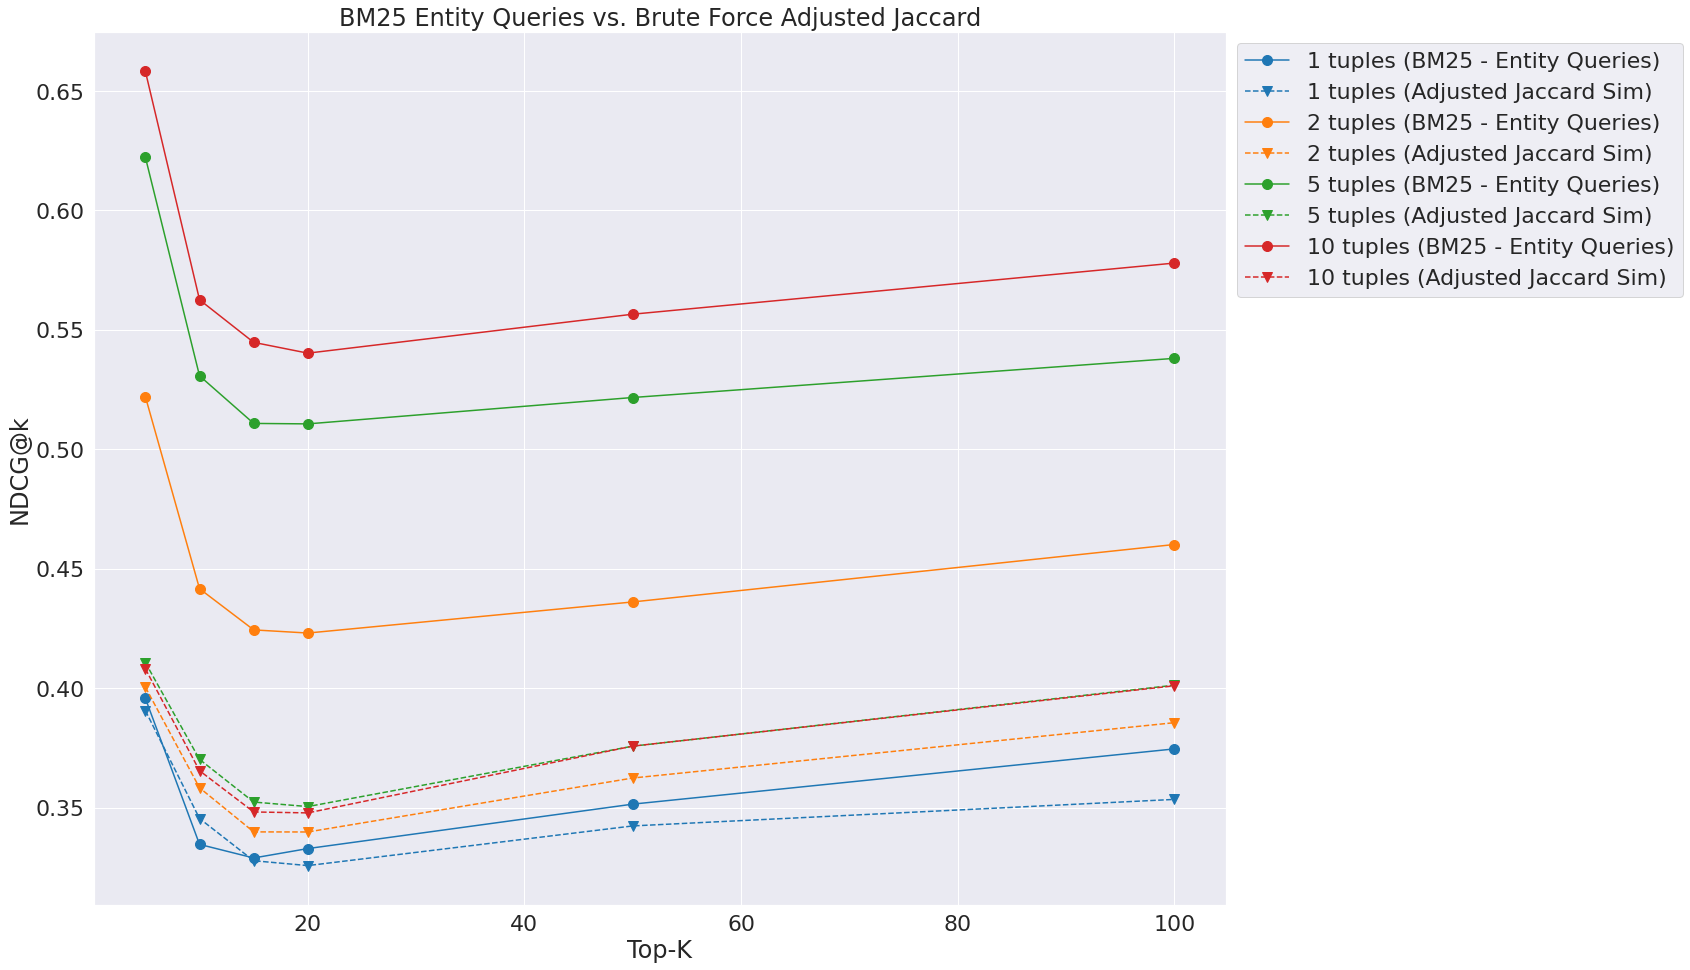

In [83]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    bm_25_mean_ndcg_scores_at_k = [dfs_dict[tuples_per_query_list[i]]['entities']['content_jaccard']['ndcg@'+str(k)].mean() for k in top_k_vals]
    brute_force_mean_ndcg_scores_at_k = mean_ndcg_scores_at_k_categories_jaccard_sim[tuples_per_query_list[i]]

    plt.plot(top_k_vals, bm_25_mean_ndcg_scores_at_k, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' tuples (BM25 - Entity Queries)', color=colors[i])
    plt.plot(top_k_vals, brute_force_mean_ndcg_scores_at_k, '--', marker='v', markersize=10, label=str(tuples_per_query_list[i]) + ' tuples (Adjusted Jaccard Sim)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('BM25 Entity Queries vs. Brute Force Adjusted Jaccard');plt.tight_layout()
plt.savefig('figures/wikipage_categories/bm25_entity_queries_vs_brute_force_adj_jaccard.svg')
plt.savefig('figures/wikipage_categories/bm25_entity_queries_vs_brute_force_adj_jaccard.png')

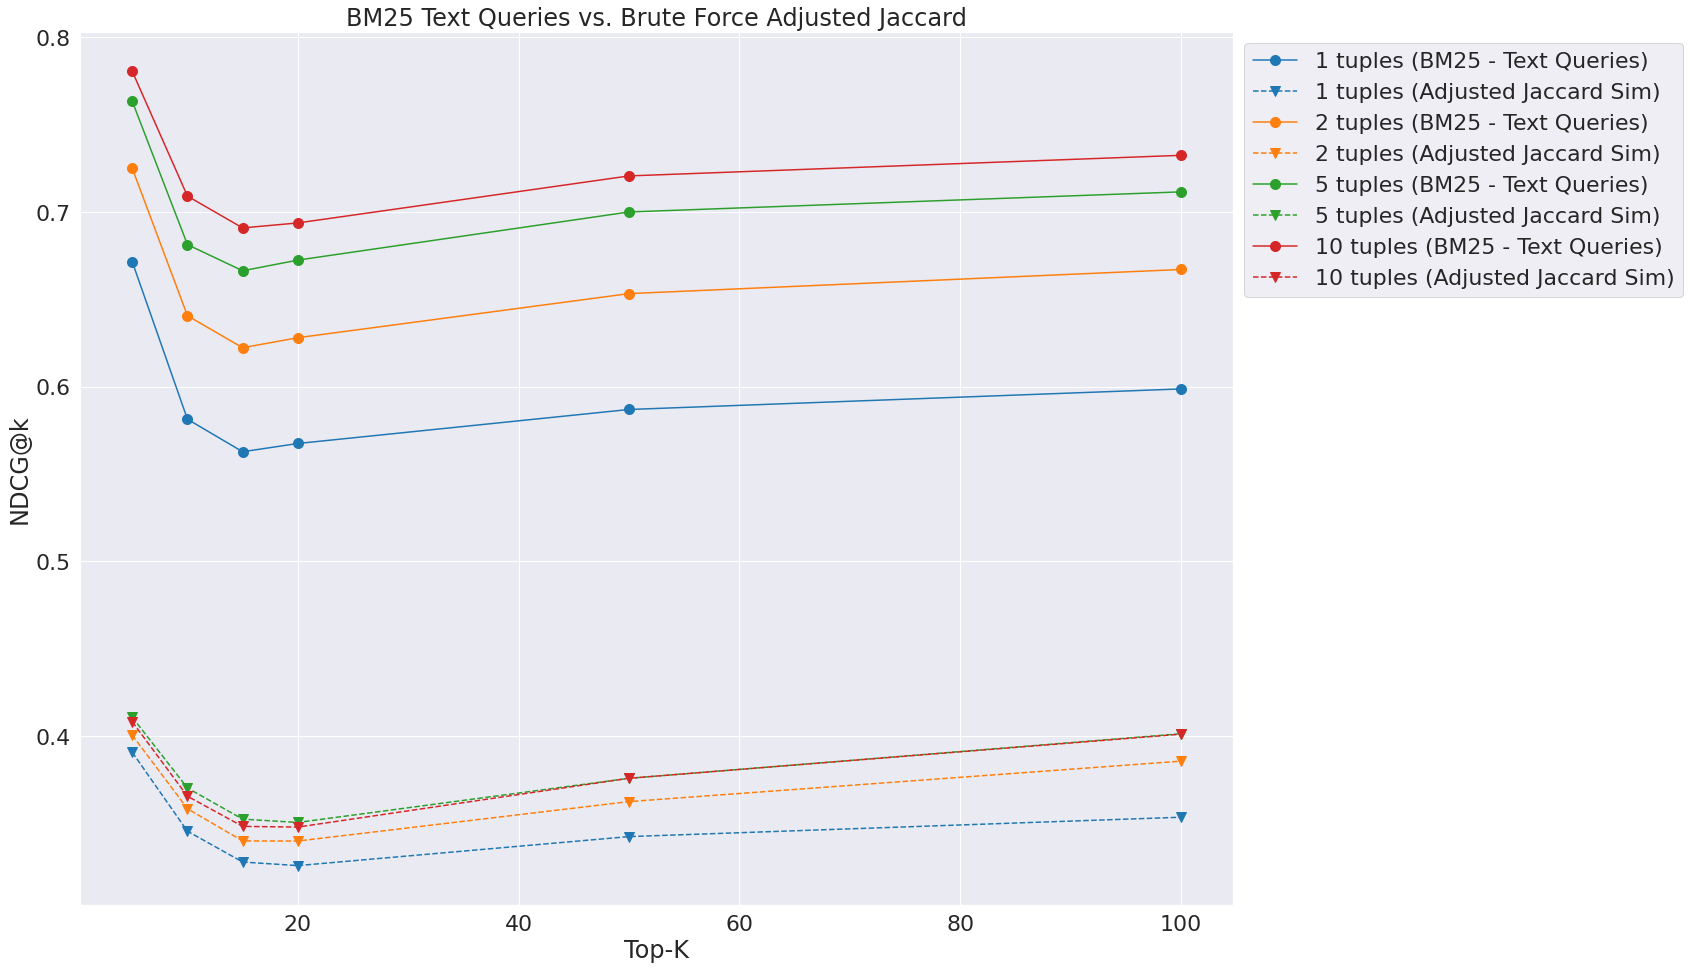

In [82]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    bm_25_mean_ndcg_scores_at_k = [dfs_dict[tuples_per_query_list[i]]['text']['content_jaccard']['ndcg@'+str(k)].mean() for k in top_k_vals]
    brute_force_mean_ndcg_scores_at_k = mean_ndcg_scores_at_k_categories_jaccard_sim[tuples_per_query_list[i]]

    plt.plot(top_k_vals, bm_25_mean_ndcg_scores_at_k, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' tuples (BM25 - Text Queries)', color=colors[i])
    plt.plot(top_k_vals, brute_force_mean_ndcg_scores_at_k, '--', marker='v', markersize=10, label=str(tuples_per_query_list[i]) + ' tuples (Adjusted Jaccard Sim)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('BM25 Text Queries vs. Brute Force Adjusted Jaccard');plt.tight_layout()
plt.savefig('figures/wikipage_categories/bm25_text_queries_vs_brute_force_adj_jaccard.svg')
plt.savefig('figures/wikipage_categories/bm25_text_queries_vs_brute_force_adj_jaccard.png')

# Query Results Exploration

## Brute Force Jaccard (10 tuples per query and NDCG@k=10)

In [36]:
def get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir):

    with open(queries_dir + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query = json.load(fp)['queries']
    print("Query:\n", query)

    with open(search_output_dir + 'wikipage_' + str(wikipage_id) + '/search_output/filenameToScore.json') as fp:
        scores = json.load(fp)['scores']
    print("\nWikipage titles of top scored tables:\n", [table['pgTitle'] for table in scores[:10]])

    with open(groundtruth_relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        wikipage_relevance_scores = json.load(fp)
    print("\nGroundtruth Wikipages relevance scores:\n", wikipage_relevance_scores)

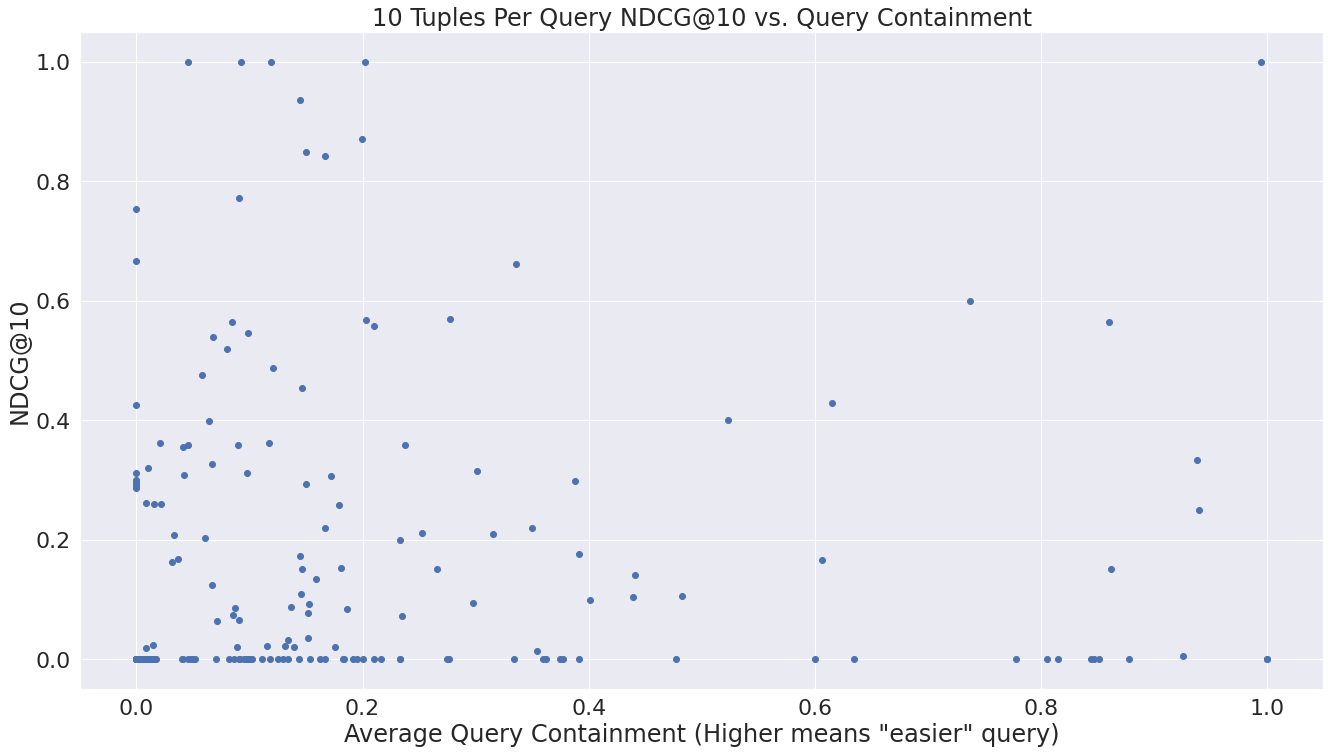

In [37]:
plt.scatter(query_df_categories_jaccard[10]['avg_query_containment'], query_df_categories_jaccard[10]['ndcg@10'])
plt.xlabel('Average Query Containment (Higher means "easier" query)');plt.ylabel('NDCG@10');plt.title('10 Tuples Per Query NDCG@10 vs. Query Containment');plt.tight_layout()
plt.savefig('figures/wikipage_categories/brute_force_jaccard_ndcg10_vs_query_containment.svg')

In [38]:
queries_dir = '../../data/queries/wikipages/queries/minTupleWidth_2_tuplesPerQuery_10/'
search_output_dir = '../../data/search/wikipages/minTupleWidth_2_tuplesPerQuery_10/jaccard/'
groundtruth_relevance_scores_dir_weighted='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/weighted/'

### Top-Right Corner (Easy Query & High NDCG score)

In [40]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] >= 0.8) & (cur_df['avg_query_containment'] >= 0.9)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
148106,https://en.wikipedia.org/wiki/List_of_the_busi...,148106,13,"[table-1012-874.json, table-1012-875.json, tab...","[217, 219, 216, 214, 214, 215, 218, 217, 217, ...",3.0,10.0,table-1012-875.json,"[2, 5, 6, 7, 9, 10, 12, 13, 14, 15]",0.994444,0.741918,0.649159,1.0,1.0,0.651331,0.969469,0.631516,0.905083


In [41]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_China 

Query:
 [['http://dbpedia.org/resource/Guangzhou_Baiyun_International_Airport', 'http://dbpedia.org/resource/Guangzhou', 'http://dbpedia.org/resource/Guangdong'], ['http://dbpedia.org/resource/Chengdu_Shuangliu_International_Airport', 'http://dbpedia.org/resource/Chengdu', 'http://dbpedia.org/resource/Sichuan'], ['http://dbpedia.org/resource/Kunming_Wujiaba_International_Airport', 'http://dbpedia.org/resource/Kunming', 'http://dbpedia.org/resource/Yunnan'], ['http://dbpedia.org/resource/Haikou_Meilan_International_Airport', 'http://dbpedia.org/resource/Haikou', 'http://dbpedia.org/resource/Hainan'], ['http://dbpedia.org/resource/Hangzhou_Xiaoshan_International_Airport', 'http://dbpedia.org/resource/Hangzhou', 'http://dbpedia.org/resource/Zhejiang'], ['http://dbpedia.org/resource/Xiamen_Gaoqi_International_Airport', 'http://dbpedia.org/resource/Xiamen', 'http://dbpedia.org/resource/Fujian'], ['http:

### Bottom-Right Corner (Easy Query & Low NDCG score)

In [47]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] <= 0.2) & (cur_df['avg_query_containment'] >= 0.8)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
46558,https://en.wikipedia.org/wiki/Ozzfest_lineups_...,46558,11,"[table-0322-581.json, table-0322-582.json, tab...","[50, 47, 43, 39, 31, 45, 50, 52, 48, 48, 47]",3.0,10.0,table-0322-581.json,"[1, 2, 3, 4, 5, 7, 8, 9, 10, 11]",0.861905,0.454997,0.484566,0.151397,0.131205,0.484566,0.240166,0.484566,0.324920
85407,https://en.wikipedia.org/wiki/List_of_minor_pl...,85407,10,"[table-0575-685.json, table-0575-686.json, tab...","[17, 17, 13, 17, 15, 14, 18, 12, 11, 21]",2.0,10.0,table-0575-693.json,"[0, 1, 3, 4, 6, 7, 8, 9, 10, 11]",0.844444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85434,https://en.wikipedia.org/wiki/List_of_minor_pl...,85434,10,"[table-0575-84.json, table-0575-85.json, table...","[17, 19, 15, 18, 19, 21, 14, 21, 18, 15]",2.0,10.0,table-0575-88.json,"[0, 2, 4, 5, 6, 7, 9, 12, 16, 17]",0.805556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85774,https://en.wikipedia.org/wiki/List_of_minor_pl...,85774,10,"[table-0578-116.json, table-0578-117.json, tab...","[15, 18, 19, 12, 15, 16, 18, 26, 19, 19]",2.0,10.0,table-0578-119.json,"[4, 7, 9, 10, 11, 12, 16, 17, 19, 20]",0.877778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85987,https://en.wikipedia.org/wiki/List_of_minor_pl...,85987,10,"[table-0579-485.json, table-0579-486.json, tab...","[17, 24, 20, 15, 15, 17, 22, 28, 18, 18]",2.0,10.0,table-0579-490.json,"[0, 1, 2, 5, 7, 10, 11, 12, 13, 15]",0.925926,0.005986,0.005986,0.005986,0.005986,0.008728,0.005986,0.007047,0.005986
86072,https://en.wikipedia.org/wiki/List_of_minor_pl...,86072,10,"[table-0580-231.json, table-0580-232.json, tab...","[13, 16, 14, 12, 19, 18, 11, 13, 15, 11]",2.0,10.0,table-0580-241.json,"[0, 3, 4, 7, 8, 11, 16, 17, 22, 23]",1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
86450,https://en.wikipedia.org/wiki/List_of_minor_pl...,86450,10,"[table-0582-917.json, table-0582-918.json, tab...","[17, 24, 12, 15, 15, 19, 19, 20, 23, 22]",2.0,10.0,table-0582-924.json,"[0, 1, 2, 3, 5, 6, 7, 9, 12, 21]",0.847222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
86681,https://en.wikipedia.org/wiki/List_of_minor_pl...,86681,10,"[table-0584-585.json, table-0584-586.json, tab...","[16, 14, 15, 13, 15, 17, 18, 16, 14, 10]",2.0,10.0,table-0584-593.json,"[1, 2, 7, 8, 9, 10, 11, 13, 14, 15]",0.814815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
86975,https://en.wikipedia.org/wiki/List_of_minor_pl...,86975,10,"[table-0586-608.json, table-0586-609.json, tab...","[10, 18, 16, 12, 10, 13, 10, 20, 22, 16]",2.0,10.0,table-0586-618.json,"[0, 1, 2, 5, 6, 7, 10, 11, 17, 19]",0.851852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
179587,https://en.wikipedia.org/wiki/List_of_England_...,179587,10,"[table-1228-884.json, table-1228-885.json, tab...","[40, 43, 24, 13, 23, 28, 33, 34, 33, 32]",2.0,10.0,table-1228-888.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.000000,0.000000,0.033056,0.000000,0.000000,0.274539,0.000000,0.065449,0.000000


In [48]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/Ozzfest_lineups_by_year 

Query:
 [['http://dbpedia.org/resource/Hartford,_Connecticut', 'http://dbpedia.org/resource/United_States', 'http://dbpedia.org/resource/XFINITY_Theatre'], ['http://dbpedia.org/resource/Camden,_New_Jersey', 'http://dbpedia.org/resource/United_States', 'http://dbpedia.org/resource/Susquehanna_Bank_Center'], ['http://dbpedia.org/resource/Corfu,_New_York', 'http://dbpedia.org/resource/United_States', 'http://dbpedia.org/resource/Darien_Lake'], ['http://dbpedia.org/resource/Bristow,_Virginia', 'http://dbpedia.org/resource/United_States', 'http://dbpedia.org/resource/Jiffy_Lube_Live'], ['http://dbpedia.org/resource/Holmdel_Township,_New_Jersey', 'http://dbpedia.org/resource/United_States', 'http://dbpedia.org/resource/PNC_Bank_Arts_Center'], ['http://dbpedia.org/resource/Noblesville,_Indiana', 'http://dbpedia.org/resource/United_States', 'http://dbpedia.org/resource/Klipsch_Music_Center'], ['http://dbpedia.org/resour

### Top-Left Corner (Hard Query & High NDCG score)

In [49]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] >= 0.9) & (cur_df['avg_query_containment'] <= 0.05)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
226516,https://en.wikipedia.org/wiki/List_of_Hewitts_...,226516,11,"[table-1539-266.json, table-1539-267.json, tab...","[22, 13, 11, 21, 10, 12, 11, 11, 12, 17, 17]",2.0,10.0,table-1539-266.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.045455,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [50]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_Hewitts_and_Nuttalls_in_Wales 

Query:
 [['http://dbpedia.org/resource/Carnedd_Llewelyn', 'http://dbpedia.org/resource/Snowdon'], ['http://dbpedia.org/resource/Carnedd_Dafydd', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Pen_yr_Ole_Wen', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Foel_Grach', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Yr_Elen', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Foel-fras', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Garnedd_Uchaf', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Llwytmor', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Pen_yr_Helgi_Du', 'http://dbpedia.org/resource/Carnedd_Llewelyn'], ['http://dbpedia.org/resource/Bera_Bach', 'http://dbpedia.org/resou

### Bottom-Left Corner (Hard Query & Low NDCG score)

In [52]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] == 0.0) & (cur_df['avg_query_containment'] <= 0.0)]
wikipage_id = cur_df.iloc[1]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,10.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
11245,https://en.wikipedia.org/wiki/List_of_Geelong_...,11245,15,"[table-0078-726.json, table-0078-727.json, tab...","[22, 62, 72, 71, 50, 27, 13, 49, 30, 40, 26, 2...",2.0,10.0,table-0078-728.json,"[2, 3, 4, 7, 8, 9, 10, 12, 13, 14]",0.0,0.030077,0.114549,0.0,0.0,0.164269,0.0,0.164269,0.000000
55376,https://en.wikipedia.org/wiki/List_of_football...,55376,23,"[table-0384-100.json, table-0384-102.json, tab...","[56, 15, 58, 13, 14, 79, 27, 12, 10, 32, 20, 1...",2.0,10.0,table-0384-103.json,"[0, 1, 4, 6, 8, 9, 10, 12, 23, 24]",0.0,0.000000,0.055698,0.0,0.0,0.152707,0.0,0.136949,0.000000
87013,https://en.wikipedia.org/wiki/List_of_Football...,87013,11,"[table-0586-799.json, table-0586-800.json, tab...","[153, 25, 22, 21, 26, 27, 24, 62, 24, 26, 22]",3.0,10.0,table-0586-799.json,"[0, 1, 2, 3, 4, 6, 8, 10, 11, 12]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
91795,https://en.wikipedia.org/wiki/List_of_cities_w...,91795,14,"[table-0618-587.json, table-0618-589.json, tab...","[50, 11, 12, 40, 11, 18, 34, 11, 57, 21, 13, 1...",2.0,10.0,table-0618-606.json,"[0, 2, 8, 9, 12, 13, 17, 19, 20, 23]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
140474,https://en.wikipedia.org/wiki/List_of_public-a...,140474,11,"[table-0959-821.json, table-0959-822.json, tab...","[10, 21, 38, 56, 47, 163, 11, 101, 51, 18, 93]",2.0,10.0,table-0959-827.json,"[0, 1, 2, 5, 6, 13, 15, 17, 21, 26]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
140677,https://en.wikipedia.org/wiki/List_of_universi...,140677,14,"[table-0961-273.json, table-0961-274.json, tab...","[20, 89, 77, 19, 12, 16, 38, 10, 83, 39, 17, 8...",2.0,10.0,table-0961-274.json,"[3, 4, 5, 7, 8, 9, 10, 11, 12, 13]",0.0,0.071990,0.158460,0.0,0.0,0.235578,0.0,0.235578,0.040573
154023,https://en.wikipedia.org/wiki/List_of_former_n...,154023,13,"[table-1051-953.json, table-1051-954.json, tab...","[49, 62, 13, 38, 29, 76, 27, 58, 44, 38, 72, 5...",3.0,10.0,table-1051-959.json,"[0, 1, 2, 5, 7, 8, 9, 10, 11, 12]",0.0,0.000000,0.000000,0.0,0.0,0.102800,0.0,0.026675,0.000000
173324,https://en.wikipedia.org/wiki/List_of_Universi...,173324,17,"[table-1186-510.json, table-1186-512.json, tab...","[18, 154, 34, 12, 20, 53, 17, 49, 15, 11, 63, ...",2.0,10.0,table-1186-512.json,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]",0.0,0.000000,0.000000,0.0,0.0,0.004640,0.0,0.004640,0.000000
197623,https://en.wikipedia.org/wiki/List_of_astronom...,197623,21,"[table-1351-390.json, table-1351-391.json, tab...","[19, 21, 35, 46, 103, 31, 19, 38, 46, 53, 84, ...",2.0,10.0,table-1351-394.json,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [53]:
print("Selected wikipage:", cur_df.iloc[1]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_Geelong_Football_Club_players 

Query:
 [['http://dbpedia.org/resource/Stephen_Lunn', 'http://dbpedia.org/resource/1980_VFL_season'], ['http://dbpedia.org/resource/Richard_Murrie', 'http://dbpedia.org/resource/1980_VFL_season'], ['http://dbpedia.org/resource/Dale_Smyth', 'http://dbpedia.org/resource/1980_VFL_season'], ['http://dbpedia.org/resource/Steve_Reynoldson', 'http://dbpedia.org/resource/1981_VFL_season'], ['http://dbpedia.org/resource/Garry_Sidebottom', 'http://dbpedia.org/resource/1981_VFL_season'], ['http://dbpedia.org/resource/Ramsay_Bogunovich', 'http://dbpedia.org/resource/1981_VFL_season'], ['http://dbpedia.org/resource/Alan_Mangels', 'http://dbpedia.org/resource/1981_VFL_season'], ['http://dbpedia.org/resource/Bernard_Toohey', 'http://dbpedia.org/resource/1981_VFL_season'], ['http://dbpedia.org/resource/Leo_King', 'http://dbpedia.org/resource/1981_VFL_season'], ['http://dbpedia.org/resource/Brian_Peake', 'http://db

## BM25 Entity Queries (10 Tuples per Query and NDCG@k=10)

In [54]:
def get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10):

    print("Query:\n", queries_dict[wikipage_id])

    topk_tables = scores_df[scores_df['wikipage_id']==wikipage_id]['table_id'].values[:k]
    topk_page_titles = []
    # Find the page titles for each table in `topk_tables`
    for table in topk_tables:
        with open(tables_dir + table) as fp:
            page_title = json.load(fp)['pgTitle']
            topk_page_titles.append(page_title)
    print("\nWikipage titles of top scored tables:\n", topk_page_titles)

    with open(groundtruth_relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        wikipage_relevance_scores = json.load(fp)
    print("\nGroundtruth Wikipages relevance scores:\n", wikipage_relevance_scores)

def get_bm25_keyword_queries(queries_path):
    '''
    Returns a dictionary keyed by the wikipage_id and maps to its respective keyword query 
    '''
    query_id_to_keyword = {}
    with open(queries_path) as file:
        queries = file.readlines()
        for query in queries:
            vals = query.split()
            wikipage_id = int(vals[0])
            keyword = ' '.join(vals[1:])
            query_id_to_keyword[wikipage_id] = keyword
    return query_id_to_keyword

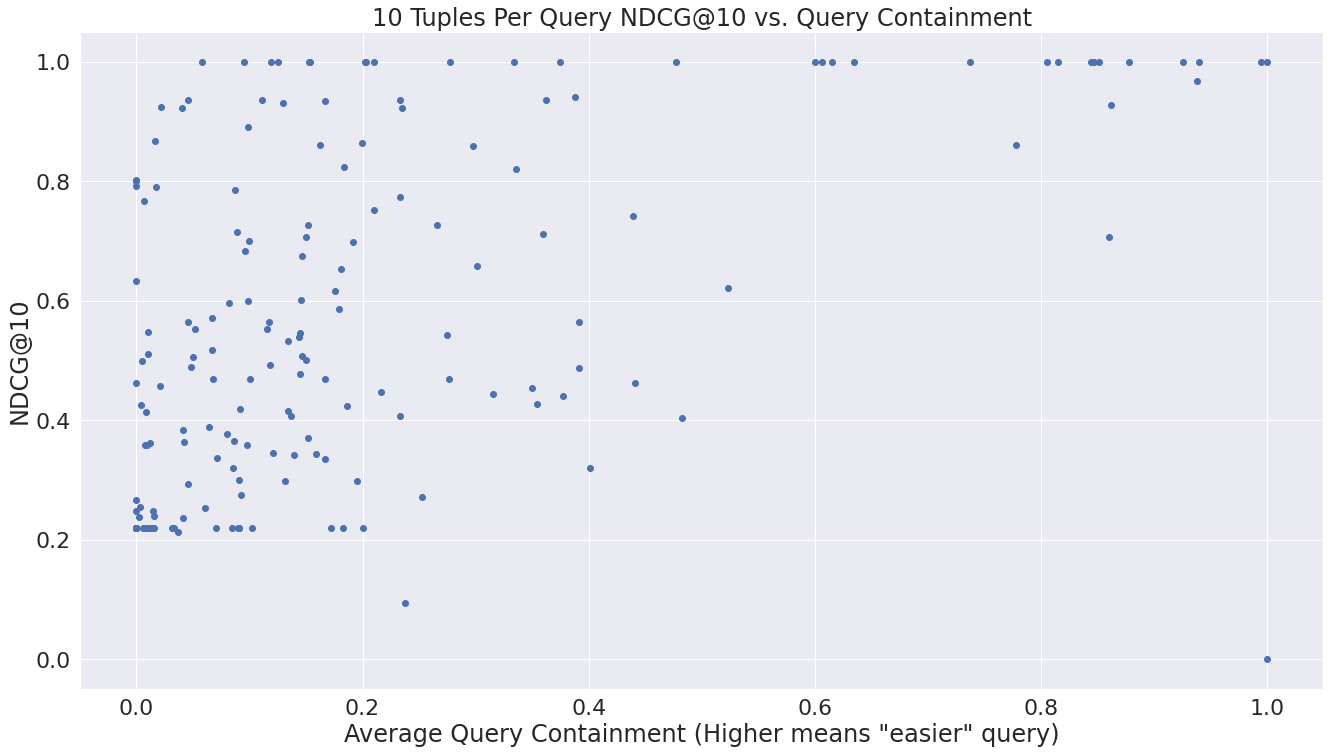

In [55]:
plt.scatter(dfs_dict[10]['entities']['content_jaccard']['avg_query_containment'], dfs_dict[10]['entities']['content_jaccard']['ndcg@10'])
plt.xlabel('Average Query Containment (Higher means "easier" query)');plt.ylabel('NDCG@10');plt.title('10 Tuples Per Query NDCG@10 vs. Query Containment');plt.tight_layout()
plt.savefig('figures/wikipage_categories/BM25_entity_queries_jaccard_ndcg10_vs_query_containment.svg')

In [56]:
queries_path = '../../Web-Table-Retrieval-Benchmark/data/wikipages/queries/minTupleWidth_2_tuplesPerQuery_10/entities/queries.txt'
scores_path = '../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/minTupleWidth_2_tuplesPerQuery_10/entities/content.txt'
groundtruth_relevance_scores_dir='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/weighted/'
tables_dir = '../../data/tables/wikipages/tables/'

# Maps each wikipage_id to its respective keyword query
queries_dict = get_bm25_keyword_queries(queries_path)

# Dataframe containing the top-100 tables from BM25 from each query
scores_df = pd.read_csv(scores_path, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])

### Bottom-Right Corner (Easy Query & low NDCG score)

In [44]:
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[(cur_df['ndcg@10'] == 0.0) & (cur_df['avg_query_containment'] >= 0.9)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
179587,https://en.wikipedia.org/wiki/List_of_England_...,179587,10,"[table-1228-884.json, table-1228-885.json, tab...","[40, 43, 24, 13, 23, 28, 33, 34, 33, 32]",2.0,10.0,table-1228-888.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,0.0,0.0,0.0,0.0,0.248042,0.380733


In [45]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_England_Test_matches 

Query:
 Oval national Melbourne Cricket Ground team The Australia cricket Sydney

Wikipage titles of top scored tables:
 ['List of Australia national rugby union team test match results', 'List of Australia national rugby union team test match results', 'List of results of the Australian national rugby league team', 'List of New Zealand rugby union Test matches', 'List of results of the Australian national rugby league team', 'List of New Zealand rugby union Test matches', 'List of results of the Australian national rugby league team', 'List of Australia national rugby union team test match results', 'List of New Zealand rugby union Test matches', 'List of results of the Australian national rugby league team']

Groundtruth Wikipages relevance scores:
 {'List_of_England_Test_matches': 1}


### Top-Left Corner (Hard Query & High NDCG score)

In [58]:
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[(cur_df['ndcg@10'] == 1.0) & (cur_df['avg_query_containment'] == 0.0)]
wikipage_id = cur_df.iloc[7]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,10.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22]",0.0,1.0,1.0,1.000000,1.000000,1.000000,0.896189
11245,https://en.wikipedia.org/wiki/List_of_Geelong_...,11245,15,"[table-0078-726.json, table-0078-727.json, tab...","[22, 62, 72, 71, 50, 27, 13, 49, 30, 40, 26, 2...",2.0,10.0,table-0078-728.json,"[2, 3, 4, 7, 8, 9, 10, 12, 13, 14]",0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
87013,https://en.wikipedia.org/wiki/List_of_Football...,87013,11,"[table-0586-799.json, table-0586-800.json, tab...","[153, 25, 22, 21, 26, 27, 24, 62, 24, 26, 22]",3.0,10.0,table-0586-799.json,"[0, 1, 2, 3, 4, 6, 8, 10, 11, 12]",0.0,1.0,1.0,1.000000,1.000000,0.650943,0.561157
91795,https://en.wikipedia.org/wiki/List_of_cities_w...,91795,14,"[table-0618-587.json, table-0618-589.json, tab...","[50, 11, 12, 40, 11, 18, 34, 11, 57, 21, 13, 1...",2.0,10.0,table-0618-606.json,"[0, 2, 8, 9, 12, 13, 17, 19, 20, 23]",0.0,1.0,1.0,1.000000,1.000000,0.721787,0.721787
97391,https://en.wikipedia.org/wiki/List_of_best-sel...,97391,10,"[table-0657-509.json, table-0657-510.json, tab...","[40, 20, 29, 45, 30, 83, 10, 44, 38, 14]",2.0,10.0,table-0657-519.json,"[0, 3, 4, 5, 6, 8, 9, 10, 12, 16]",0.0,1.0,1.0,1.000000,1.000000,0.721787,0.721787
140677,https://en.wikipedia.org/wiki/List_of_universi...,140677,14,"[table-0961-273.json, table-0961-274.json, tab...","[20, 89, 77, 19, 12, 16, 38, 10, 83, 39, 17, 8...",2.0,10.0,table-0961-274.json,"[3, 4, 5, 7, 8, 9, 10, 11, 12, 13]",0.0,1.0,1.0,1.000000,1.000000,0.735777,0.556351
154023,https://en.wikipedia.org/wiki/List_of_former_n...,154023,13,"[table-1051-953.json, table-1051-954.json, tab...","[49, 62, 13, 38, 29, 76, 27, 58, 44, 38, 72, 5...",3.0,10.0,table-1051-959.json,"[0, 1, 2, 5, 7, 8, 9, 10, 11, 12]",0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
164705,https://en.wikipedia.org/wiki/List_of_urban_ra...,164705,10,"[table-1121-54.json, table-1121-62.json, table...","[27, 12, 37, 22, 15, 44, 21, 17, 17, 10]",2.0,10.0,table-1121-80.json,"[8, 12, 14, 15, 16, 17, 18, 19, 20, 26]",0.0,1.0,1.0,0.984948,0.984948,0.984948,0.956490
170297,https://en.wikipedia.org/wiki/Regional_Trial_C...,170297,14,"[table-1163-298.json, table-1163-299.json, tab...","[13, 30, 23, 25, 25, 19, 11, 33, 27, 27, 47, 2...",2.0,10.0,table-1163-308.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
173324,https://en.wikipedia.org/wiki/List_of_Universi...,173324,17,"[table-1186-510.json, table-1186-512.json, tab...","[18, 154, 34, 12, 20, 53, 17, 49, 15, 11, 63, ...",2.0,10.0,table-1186-512.json,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]",0.0,1.0,1.0,1.000000,1.000000,1.000000,0.713523


In [59]:
print("Selected wikipage:", cur_df.iloc[7]['wikipage'], '\n')
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_urban_rail_systems_in_Japan 

Query:
 Oshiage Keisei Railway Corporation Kanamachi Chihara Airport Sagami Electric Keio Main Higashi-Narita Narita Inokashira Line Chiba Sagamihara

Wikipage titles of top scored tables:
 ['List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', "World's busiest airports by cargo traffic", "World's busiest airports by cargo traffic", "World's busiest airports by cargo traffic"]

Groundtruth Wikipages relevance scores:
 {'List_of_urban_rail_systems_in_Japan': 1.0}


### List_of_minor_planets:_211001–212000

In [72]:
wikipage_id = 85987
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[cur_df['wikipage_id'] == wikipage_id]
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
85987,https://en.wikipedia.org/wiki/List_of_minor_pl...,85987,10,"[table-0579-485.json, table-0579-486.json, tab...","[17, 24, 20, 15, 15, 17, 22, 28, 18, 18]",2.0,10.0,table-0579-490.json,"[0, 1, 2, 5, 7, 10, 11, 12, 13, 15]",0.925926,1.0,1.0,1.0,1.0,1.0,0.999414


In [73]:
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Query:
 Kitt Search Near-Earth-Object Lemmon Mesa Station Anderson Peak Spacewatch Observatory Lowell Mount Survey National

Wikipage titles of top scored tables:
 ['List of minor planets: 207001–208000', 'List of minor planets: 212001–213000', 'List of minor planets: 209001–210000', 'List of minor planets: 199001–200000', 'List of minor planets: 204001–205000', 'List of minor planets: 212001–213000', 'List of minor planets: 199001–200000', 'List of minor planets: 199001–200000', 'List of minor planets: 207001–208000', 'List of minor planets: 212001–213000']

Groundtruth Wikipages relevance scores:
 {'List_of_minor_planets:_211001–212000': 1.0, 'List_of_minor_planets:_212001–213000': 1.0, 'List_of_minor_planets:_209001–210000': 1.0, 'List_of_minor_planets:_208001–209000': 1.0, 'List_of_minor_planets:_207001–208000': 1.0, 'List_of_minor_planets:_206001–207000': 1.0, 'List_of_minor_planets:_204001–205000': 1.0, 'List_of_minor_planets:_202001–203000': 1.0, 'List_of_minor_planets:_201001–2

### List_of_public-access_TV_stations_in_the_United_States_(Nebraska-Pennsylvania)

In [68]:
wikipage_id=140474
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[cur_df['wikipage_id'] == wikipage_id]
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
140474,https://en.wikipedia.org/wiki/List_of_public-a...,140474,11,"[table-0959-821.json, table-0959-822.json, tab...","[10, 21, 38, 56, 47, 163, 11, 101, 51, 18, 93]",2.0,10.0,table-0959-827.json,"[0, 1, 2, 5, 6, 13, 15, 17, 21, 26]",0.0,1.0,0.975788,0.975788,0.975788,0.92827,0.888216


In [69]:
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Query:
 Bridgewater-Raritan Grove, Institute City College Bergen, Bergen District Hill, Edison, of Matawan-Aberdeen School Hill Aberdeen Camden, Bayville, Gloucester Bridgewater Township, Central Burlington Jersey County, Schools Community High Rancocas Technology County Camden Grove Township Public Cedar Cherry Edison New Regional Valley

Wikipage titles of top scored tables:
 ['List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of Missouri high schools by athletic conferences', 'List of university and college name changes in the United States', 'List of university and college name changes in the United States', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of bus tr

In [58]:
wikipage_id=11245
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[cur_df['wikipage_id'] == wikipage_id]
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)
cur_df

Query:
 Mangels Alan Leo Steve 1981 Stephen Peake Sidebottom Richard Lunn Smyth Bogunovich Reynoldson VFL 1980 Ramsay Bernard Brian Toohey season Murrie King Dale Garry

Wikipage titles of top scored tables:
 ['List of Geelong Football Club players', 'List of North Melbourne Football Club players', '2007–08 NBL season', 'List of Essendon Football Club players', 'List of St Kilda Football Club players', 'List of New South Wales rugby league team squads', 'List of Sydney Swans players', 'List of Richmond Football Club players', 'List of Hawthorn Football Club players', 'List of Hawthorn Football Club players']

Groundtruth Wikipages relevance scores:
 {'List_of_Geelong_Football_Club_players': 1.0}


,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
11245,https://en.wikipedia.org/wiki/List_of_Geelong_...,11245,15,"[table-0078-726.json, table-0078-727.json, tab...","[22, 62, 72, 71, 50, 27, 13, 49, 30, 40, 26, 2...",2.0,10.0,table-0078-728.json,"[2, 3, 4, 7, 8, 9, 10, 12, 13, 14]",0.0,0.33916,0.220092,0.170609,0.170609,0.170609,0.170609


# Testing

In [34]:
true_relevance = np.asarray([np.random.randint(5, size=10)])
scores = np.asarray([np.random.randint(5, size=10)])
ndcg_score(true_relevance, scores, k=100)

0.8712636695836269

In [35]:
ndcg_score(true_relevance, scores)

0.8712636695836269

In [44]:
true_relevance = np.asarray([[2, 1, 1, 0, 0, 0, 0]])
scores = np.asarray([[1, 0.4, 0.5, 0, 1, 2, 0]])
ndcg_score(true_relevance, scores)

0.6223260412204333

In [24]:
with open('eval_over_search_output/wikipage_categories_relevant/minTupleWidth_2_tuplesPerQuery_20/jaccard/scores_over_output_100.json', 'r') as fp:
    json_file = json.load(fp)

ndcg_scores = []
for wikipage in json_file:
    ndcg_scores.append(json_file[wikipage]['ndcg'])
print(np.mean(ndcg_scores))

0.2471694369216246
